In [1]:
!pip install torchvision tensorboardx jupyter matplotlib numpy

In [2]:
from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.optim import Adam
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from utils import Logger

In [3]:
# Root directory for dataset
dataroot = "dogs"

# Directory for checkpointing model and parameters state
checkpointsroot = "checkpoints/dogs"

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28


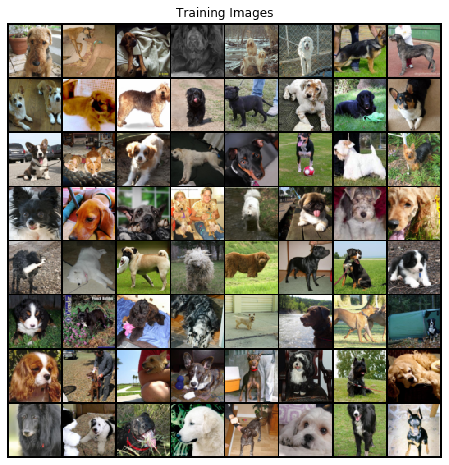

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(64),
                              transforms.CenterCrop(64),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))

# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True)

num_batches = len(data_loader)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))


In [5]:

class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [6]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [7]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [8]:

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [9]:

# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [18]:
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCEWithLogitsLoss()

# Number of epochs
num_epochs = 100

In [19]:

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [20]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [21]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [22]:
num_test_samples = 16
test_noise = noise(num_test_samples)

Epoch: [0/100], Batch Num: [0/160]
Discriminator Loss: 1.0110, Generator Loss: 0.6909
D(x): 0.9931, D(G(z)): 0.0053


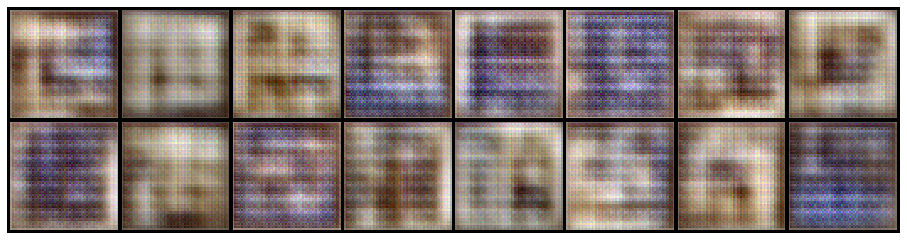

Epoch: [1/100], Batch Num: [0/160]
Discriminator Loss: 1.0069, Generator Loss: 0.6930
D(x): 0.9994, D(G(z)): 0.0006


KeyboardInterrupt: 

In [25]:
logger = Logger(model_name='DCGAN', data_name='CIFAR10')
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) == 0:
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            # Model Checkpoints
            logger.save_models(generator, discriminator, epoch)
